In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from scipy import integrate
import scipy as sc
from funcs import *
from scipy.integrate import odeint
np.set_printoptions(precision=3, suppress=True)
%matplotlib notebook
## Python 3.11.4

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["CMU"],
})

## Bifurcación de Hopf

$$\dot{x}=\mu x - \omega y-Ax(x^2+y^2)$$
$$\dot{y}=\omega x +\mu y-Ay(x^2+y^2)$$

In [2]:
def hopf(x, mu, omega, A):
    return [
        mu * x[0] - omega * x[1] - A * x[0] * (x[0] ** 2 + x[1] ** 2),
        omega * x[0] + mu * x[1] - A * x[1] * (x[0] ** 2 + x[1] ** 2),
    ]

# Generate training data
omega = 1
A = 1
tf = 75
dt = 0.01
t_train = np.arange(0, tf, dt)

new_step = int(tf/dt)

mu_stable = np.array([-0.3, -0.25, -0.2, -0.15, -0.10, -0.05])      # EQUILIBRIUM POINTS
mu_unstable = np.array([0.01, 0.05, 0.10, 0.15, 0.2, 0.3, 0.4, 0.5])  # LIMIT CYCLES

n_ics = mu_stable.size + mu_unstable.size  # *2
x_train = [np.zeros((t_train.size, 3)) for i in range(n_ics)]
ic_idx = 0

pts_eq = np.zeros((mu_stable.size, 3))

for mu in mu_stable:
    x0_train = [2, 0]
    x = odeint(lambda x, t: hopf(x, mu, omega, A), x0_train, t_train, rtol=1e-10)
    x_train[ic_idx][:, :2] = x 
    x_train[ic_idx][:, 2] = mu
    
    pts_eq[ic_idx, :2] = 0  # x[-1]
    pts_eq[ic_idx, 2] = mu
    
    ic_idx += 1

for mu in mu_unstable:
    x0_train = [2, 0]
    x = odeint(lambda x, t: hopf(x, mu, omega, A), x0_train, t_train, rtol=1e-10)
    x_train[ic_idx][:, 0:2] = x
    x_train[ic_idx][:, 2] = mu
    ic_idx += 1

<IPython.core.display.Javascript object>


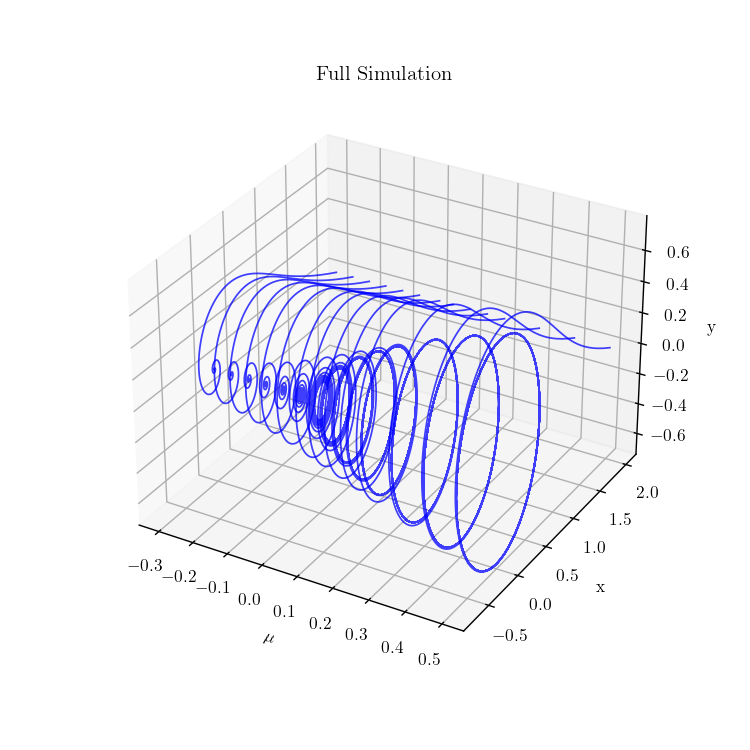

In [3]:
plot_kws=dict(alpha=0.75, linewidth=1)
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
for i in range(n_ics):
    ax.plot(x_train[i][:, 2], x_train[i][:, 0], x_train[i][:, 1], "b", **plot_kws)

ax.set(title="Full Simulation", xlabel="$\mu$", ylabel="x", zlabel="y");

In [4]:
'''
CONCATENATE DATA
'''
x_real = np.array(x_train).reshape((n_ics*t_train.size, 3))
t_real = np.array(list(t_train)*n_ics)

x_real.shape, t_real.shape, new_step

((105000, 3), (105000,), 7500)

In [5]:
true_dynamics = mysindy2(x_real, t_real, 0.1, 4, normalize=True)
print("+".join([f'{f:2.1f} '+s for s, f in zip(true_dynamics[1], true_dynamics[0][:, 0]) if not np.abs(f) < 1e-2]))
print("+".join([f'{f:2.1f} '+s for s, f in zip(true_dynamics[1], true_dynamics[0][:, 1]) if not np.abs(f) < 1e-2]))
true_dynamics_4 = mysindy2(x_real, t_real, 0.1, 4, normalize=True)[0]

-1.0 y+1.0 x u+-1.0 x^3+-1.0 x y^2
1.0 x+1.0 y u+-1.0 x^2 y+-1.0 y^3


In [6]:
n_est = int(68.7/dt)  # consider from this point on to be stationary

limit_cycle_start = mu_stable.size + 1 

'''
CREATE STATIONARY DATA ARRAYS
'''
x_est = est(x_real[new_step*limit_cycle_start:, :], n_est, new_step, n_ics-limit_cycle_start)
t_est = np.array(list(t_real[n_est:new_step])*(n_ics-limit_cycle_start))
pts_eq

n_att = int(x_est.shape[0]/7)

<IPython.core.display.Javascript object>


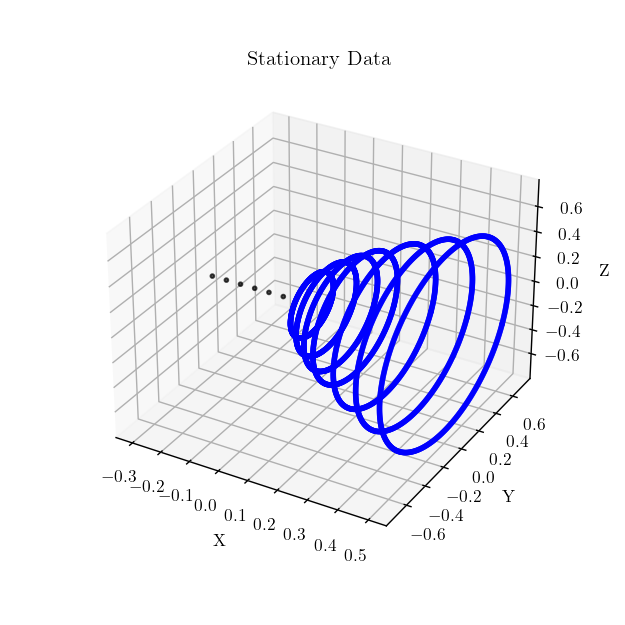

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
plt.title('Stationary Data')

# Set scatter plot color and size
ax.scatter(x_est[:, 2], x_est[:, 0], x_est[:, 1], c='blue', alpha=0.7, s=5)
ax.scatter(pts_eq[:, 2], pts_eq[:, 0], pts_eq[:, 1], c='black', alpha=0.7, s=5)

plt.show()

In [8]:
def musindy(X, t, polyorder, lamb, alpha, dX):
    '''
    Returns a sequential threshholded sparse regression by applying constrained-least-squares regression recursively
    to a pre-normalized candidate library matrix by its maximum value.

    polyorder: Polynomial Order

    '''
    vals, dims = X.shape  # dims --> number of columns

#     dX = deriv4_time(X, t)

    library = PolynomialFeatures(polyorder)
    THETA = library.fit_transform(X)
    variable_names = library.fit(X[:dims, :]).get_feature_names_out(['x', 'y', 'u'][0:dims])

    l = THETA.shape[1]

    # Initialize constraints -------------------------------------------------------------------------
    n_constraints = pts_eq.shape[0] + ptss.shape[0] 

    C = np.zeros((n_constraints, l))
    d = np.zeros((n_constraints, dims))

    idx = 0  # Index for row of C and element of vector d

    for p in ptss:         
        arr = library.fit_transform(np.array([p])).flatten()
        C[idx, :] = arr
        d[idx] = ptss_dx[idx, :]
        idx += 1

    for p in pts_eq:         
        arr = library.fit_transform(np.array([p])).flatten()
        C[idx, :] = arr
        idx += 1

    # -------------------------------------------------------------------------------------------------
    THETA_C = np.r_[THETA, np.sqrt(alpha)*C]
    dX = np.r_[dX, np.sqrt(alpha)*d]

    # -------------------------------------------------------------------------------------------------
    #NORMALIZE COLUMNS
    THETAp = np.zeros_like(THETA_C)
    norms = np.zeros(THETA_C.shape[1])
    for i in range(THETA_C.shape[1]):
        
        norms[i] = np.max(np.abs(THETA_C[:, i]))
        THETAp[:, i] = THETA_C[:, i]/np.max(np.abs(THETA_C[:, i]))
        
    THETA = THETAp
    # -------------------------------------------------------------------------------------------------

    # Initial guess
    CHI = np.linalg.pinv(THETA)@dX

    # Seq. Threshholding
    for k in range(5):
        for i in range(dims):
            lamb2 = np.max(np.abs(CHI[:, i]))*lamb
#             lamb2 = np.mean(np.abs(CHI[:, i]))*lamb
            smallinds = np.abs(CHI[:, i]) < lamb2
            CHI[smallinds, i] = 0  # Mask
            biginds = smallinds == 0
            CHI[biginds, i] = np.linalg.pinv(THETA[:, biginds])@dX[:, i]

    for i in range(dims):
        CHI[:, i] = CHI[:, i]/norms

    return CHI, variable_names, polyorder

In [9]:
'''
OBTAIN [HIGH FIDELITY] POINTS FOR CONSTRAINTS                                           ADD NOISE TO THE EQUILIBRIA HERE
'''
space = 110 # separation between sampled points

sampling = BurstSampling(x_est, t_est, 5, space)

ptss_dx = sampling[0]
ptss = sampling[1]
t_pts = sampling[2]
ptss_total = sampling[3]
t_total = sampling[4]

In [10]:
n_tr = 2000
T = mu_stable.size
few_X = x_train[T][:n_tr, :]
few_t = t_train[:n_tr]

In [11]:
coefw = musindy(few_X, few_t, 4, 0.006, 1e4, deriv4_time(few_X, few_t))
coefw[0]

array([[ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0., -1., -0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0., -0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [12]:
LAMBDA = 0.06
ALPHA = 1e14

In [13]:
coef = musindy(few_X, few_t, 4, LAMBDA, ALPHA, deriv4_time(few_X, few_t))
coef[0]

array([[ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ],
       [-1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.997,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.997,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [-0.997,  0.   ,  0.   ],
       [ 0.   , -0.997,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [-0.997,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   , -0.997,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0

## HEATMAP

In [14]:
from numpy.linalg import norm
from numpy.random import normal, permutation, seed

grid_length = 11
seeds = np.arange(0, (grid_length**2)*1000+1, 1)*10

Ec_14_final = []
Ec_1_final = []
Ec_30_final = []

Em_14_final = []
Em_1_final = []
Em_30_final= []

rango_ruido = np.linspace(0, 0.05, grid_length)
rango_l = np.linspace(n_tr, 5, grid_length, dtype=int)  # 500

seed_idx = 0
for noise in rango_ruido:
    Ec_14_inicial = []
    Ec_1_inicial = []
    Ec_30_inicial= []
    
    Em_14_inicial = []
    Em_1_inicial = []
    Em_30_inicial = []
    for largo in rango_l:
        for i in range(500):   # ITERATIONS HERE
            seed(seeds[seed_idx])
            '''
            CHOOSE 1 TRANSIENT FOR THE REGRESSION                                             ADD NOISE TO THE TRANSIENT HERE
            '''
            eps = noise            # eps = 0.025;
            signal_power = np.sqrt(np.mean(x_train[T][:n_tr, :]**2))   # Potencia del transiente
            sigma = eps*signal_power  # signal power is rms

            x_Trans2 = few_X + np.c_[sigma * normal(size=(n_tr, 2)), np.zeros(n_tr)]  # NO NOISE ON PARAMETERS
            x_Trans_prior = x_Trans2
            t_Trans_prior = few_t
            dX_prior = deriv4_time(x_Trans_prior, t_Trans_prior)

            '''
            apply algorithm to decimated arrays
            '''
            data_length = largo
            mask = np.sort(permutation(np.arange(x_Trans_prior.shape[0]))[:data_length])

            x_Trans = x_Trans_prior[mask]
            t_Trans = t_Trans_prior[mask]
            dX = dX_prior[mask]

            coeffsw = musindy(x_Trans, t_Trans, 4, LAMBDA, ALPHA, dX)
            coeffs_OG = musindy(x_Trans, t_Trans, 4, LAMBDA, 1, dX)

            # ------------------------------------------------- MODEL ERROR --------------------------------

            Ec_14_inicial.append(norm(coeffsw[0]-true_dynamics_4, ord='fro')/norm(true_dynamics_4, ord='fro'))
            Ec_1_inicial.append(norm(coeffs_OG[0]-true_dynamics_4, ord='fro')/norm(true_dynamics_4, ord='fro'))

            # --------------------------------------------------- SUCCESS RATE ---------------------------------
            sparsity_true = (abs(true_dynamics_4) > 0.001)*1
            sparsity_w = (abs(coeffsw[0]) > 0.001)*1
            sparsity_OG = (abs(coeffs_OG[0]) > 0.001)*1
    
            if norm(sparsity_true - sparsity_w) < 1e-3:
                Em_14_inicial.append(1)
            else:
                Em_14_inicial.append(0)

            if norm(sparsity_true - sparsity_OG) < 1e-3:
                Em_1_inicial.append(1)
            else:
                Em_1_inicial.append(0)

            seed_idx += 1

        Em_14_final.append(np.mean(Em_14_inicial))
        Em_1_final.append(np.mean(Em_1_inicial))
        
        Ec_14_final.append(np.mean(Ec_14_inicial))
        Ec_1_final.append(np.mean(Ec_1_inicial))

<IPython.core.display.Javascript object>


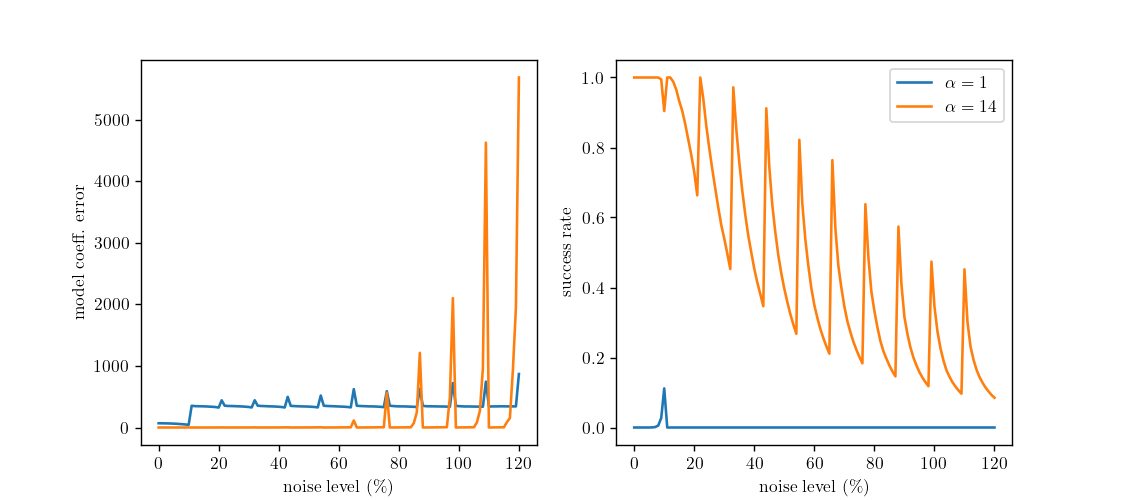

In [15]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(9,4))

# Plot the data for Ec_og0 and Ec_musindy0 on the first subplot
axs[0].plot(Ec_1_final, label='$\\alpha = 1$')
axs[0].plot(Ec_14_final, label='$\\alpha = 14$')
# axs[0].plot(Ec_30_final, label='$\\alpha = 20$')
axs[0].set_xlabel('noise level (\%)')
axs[0].set_ylabel('model coeff. error')

# Plot the data for Em_og0 and Em_musindy0 on the second subplot
axs[1].plot(Em_1_final, label='$\\alpha = 1$')
axs[1].plot(Em_14_final, label='$\\alpha = 14$')
# axs[1].plot(Em_30_final, label='$\\alpha = 20$')
axs[1].set_xlabel('noise level (\%)')
axs[1].set_ylabel('success rate')

# Show the plot
plt.legend()
plt.show()

In [16]:
EC_MUSINDY = np.zeros((len(rango_ruido), len(rango_l)))
EC_OG = np.zeros_like(EC_MUSINDY)

EM_MUSINDY = np.zeros_like(EC_MUSINDY)
EM_OG = np.zeros_like(EC_MUSINDY)


iii = 0
for i in range(len(rango_ruido)): #noise
    for j in range(len(rango_l)): #largo
        EC_MUSINDY[(len(rango_l)-1)-j, i] = Ec_14_final[iii]
        EC_OG[(len(rango_l)-1)-j, i] = Ec_1_final[iii]
        EM_MUSINDY[(len(rango_l)-1)-j, i] = Em_14_final[iii]
        EM_OG[(len(rango_l)-1)-j, i] = Em_1_final[iii]
        iii += 1

In [17]:
# from scipy.io import savemat, loadmat

# dicc = {'EC_OG': EC_OG,
#         'EC_MUSINDY': EC_MUSINDY,
#         'EM_OG': EM_OG,
#         'EM_MUSINDY': EM_MUSINDY    
#        }

# savemat('heat_data_hopf.mat', dicc)

In [18]:
# from scipy.io import loadmat

# DF = loadmat('heat_data_hopf.mat')
# EC_OG = DF['EC_OG']
# EC_MUSINDY = DF['EC_MUSINDY']
# EM_OG = DF['EM_OG']
# EM_MUSINDY = DF['EM_MUSINDY']

<IPython.core.display.Javascript object>


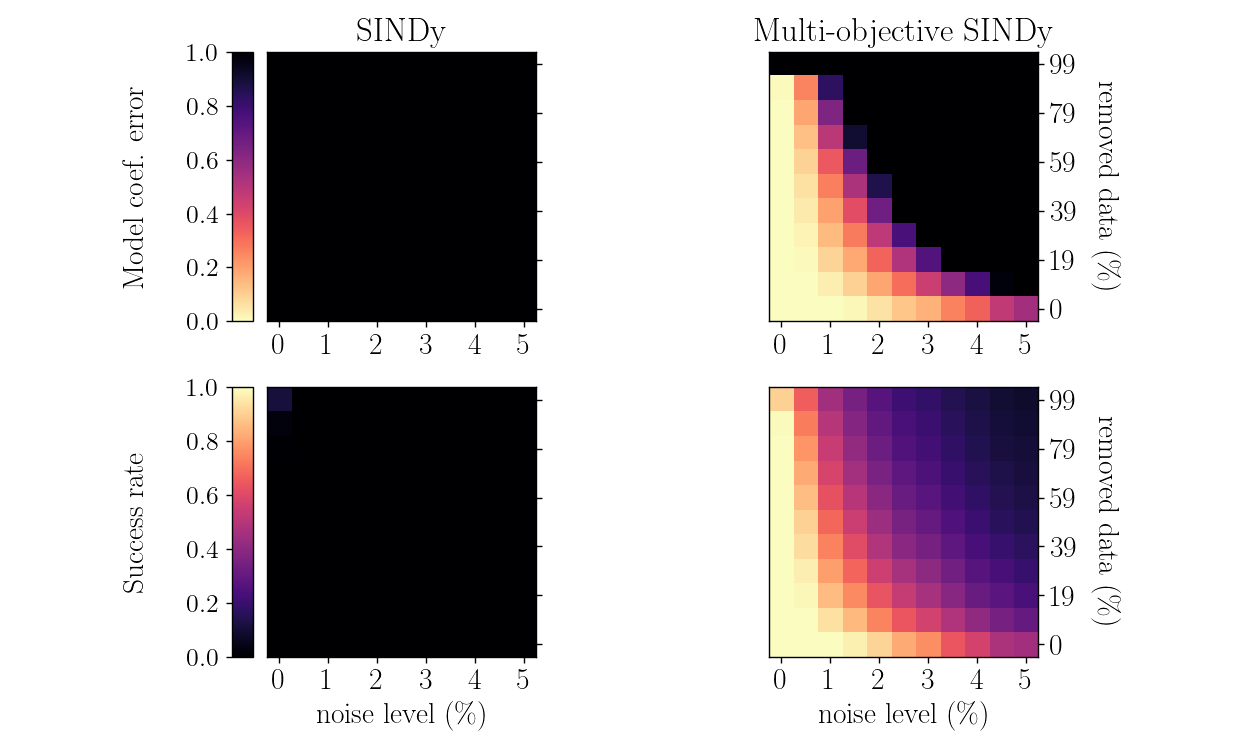

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1, 1]})

vmin = 0
vmax = 1

xticks = np.round(np.linspace(rango_ruido[0], rango_ruido[-1], 6, endpoint=True) * 100)
yticks = np.linspace((1-rango_l[-1]/rango_l[0])*100, 0, 6, endpoint=True, dtype=int)

FTSIZE = 17

# Gráfico 1
im1 = axs[0, 0].imshow(EC_OG, cmap='magma_r', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('SINDy', fontsize=FTSIZE+2)
axs[0, 0].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 0].set_xticklabels(xticks.astype(int), fontsize=FTSIZE)  # Set x-axis tick labels as integers 
axs[0, 0].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 0].set_yticklabels(yticks, fontsize=FTSIZE)
axs[0, 0].tick_params(axis='y', right=True, left=False, labelright=False, labelleft=False)
axs[0, 0].set_ylabel('Success rate', fontsize=FTSIZE, labelpad=20)

# Remove y-label of the leftmost plot
axs[0, 0].set_ylabel('')

axs[0, 1].tick_params(axis='y', right=True, left=False, labelright=True, labelleft=False)

# Gráfico 2
im2 = axs[0, 1].imshow(EC_MUSINDY, cmap='magma_r', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Multi-objective SINDy', fontsize=FTSIZE+2)
axs[0, 1].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 1].set_xticklabels(xticks.astype(int), fontsize=FTSIZE)  # Set x-axis tick labels as integers
axs[0, 1].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 1].set_yticklabels(yticks, fontsize=FTSIZE)
axs[0, 1].set_ylabel('removed data (\%)', fontsize=FTSIZE, rotation=270, labelpad=25)

# -----------------------------------------------------------------------------------------------------------------------

vmin2 = 0
vmax2 = 1

# Gráfico 4
im4 = axs[1, 0].imshow(EM_OG, cmap='magma', vmin=vmin2, vmax=vmax2)
axs[1, 0].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 0].set_xticklabels(xticks.astype(int), fontsize=FTSIZE)  # Set x-axis tick labels as integers
axs[1, 0].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 0].set_yticklabels(yticks, fontsize=FTSIZE)
axs[1, 0].tick_params(axis='y', right=True, left=False, labelright=False, labelleft=False)

# Gráfico 5
im5 = axs[1, 1].imshow(EM_MUSINDY, cmap='magma', vmin=vmin2, vmax=vmax2)
axs[1, 1].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 1].set_xticklabels(xticks.astype(int), fontsize=FTSIZE)  # Set x-axis tick labels as integers
axs[1, 1].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 1].set_yticklabels(yticks, fontsize=FTSIZE)
axs[1, 1].tick_params(axis='y', right=True, left=False, labelright=True, labelleft=False)

axs[1, 1].set_ylabel('removed data (\%)', fontsize=FTSIZE, rotation=270, labelpad=25)

# -----------------------------------------------------------------------------------------------------------------------

# Add x-axis labels to the bottom subplots
axs[1, 0].set_xlabel('noise level (\%)', fontsize=FTSIZE)
axs[1, 1].set_xlabel('noise level (\%)', fontsize=FTSIZE)

# Move y-axis labels to the right of the rightmost plot
axs[0, 1].yaxis.set_label_position("right")
axs[1, 1].yaxis.set_label_position("right")

# Add colorbars to the left of every row
divider1 = make_axes_locatable(axs[0, 0])
cax1 = divider1.append_axes("left", size="8%", pad='5%')
cax1.tick_params(labelsize=15)
cbar1 = plt.colorbar(im2, cax=cax1)
cbar1.set_label('Model coef. error', fontsize=17, labelpad=-75, rotation=90)
cbar1.ax.yaxis.set_ticks_position("left")

divider2 = make_axes_locatable(axs[1, 0])
cax2 = divider2.append_axes("left", size="8%", pad='5%')
cax2.tick_params(labelsize=15)
cbar2 = plt.colorbar(im4, cax=cax2)
cbar2.set_label('Success rate', fontsize=17, labelpad=-75, rotation=90)
cbar2.ax.yaxis.set_ticks_position("left")

# Ajustar el espaciado entre subtramas
plt.tight_layout()

# Mostrar el gráfico
plt.show()
plt.savefig('hopf_heatmap.pdf')

<IPython.core.display.Javascript object>


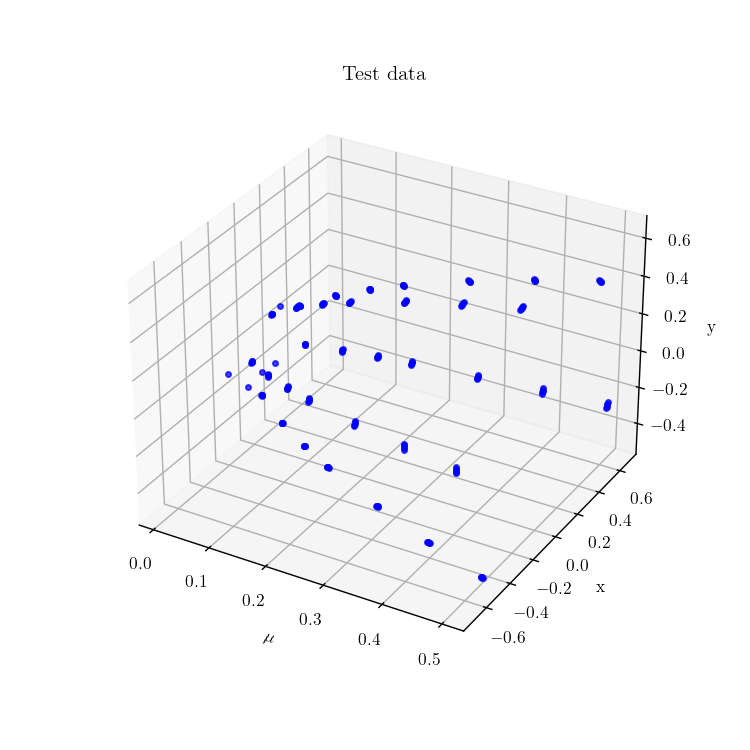

In [20]:
fig = plt.figure(figsize=(6, 6))
plot_kws=dict(alpha=0.75, linewidth=2)

ax = fig.add_subplot(projection="3d")

ax.plot(np.r_[x_Trans, ptss_total][:, -1], np.r_[x_Trans, ptss_total][:, 0], np.r_[x_Trans, ptss_total][:, 1], ".b", **plot_kws)
# ax.plot(x_Trans[:, -1], x_Trans[:, 0], x_Trans[:, 1], "r", **plot_kws)

ax.set(title="Test data", xlabel="$\mu$", ylabel="x", zlabel="y");

In [21]:
def musindy2(X, t, polyorder, lamb, alpha):
    '''
    Returns a sequential threshholded sparse regression by applying constrained-least-squares regression recursively
    to a pre-normalized candidate library matrix by its maximum value.

    polyorder: Polynomial Order

    '''
    vals, dims = X.shape  # dims --> number of columns

    dX = deriv4_time(X, t)

    library = PolynomialFeatures(polyorder)
    THETA = library.fit_transform(X)
    variable_names = library.fit(X[:2, :]).get_feature_names_out(['x', 'y', 'u'][0:dims])

    l = THETA.shape[1]

    # Initialize constraints -------------------------------------------------------------------------
    n_constraints = pts_eq.shape[0] + ptss.shape[0] 

    C = np.zeros((n_constraints, l))
    d = np.zeros((n_constraints, dims))

    idx = 0  # Index for row of C and element of vector d

    for p in ptss:         
        arr = library.fit_transform(np.array([p])).flatten()
        C[idx, :] = arr
        d[idx] = ptss_dx[idx, :]
        idx += 1

    for p in pts_eq:         
        arr = library.fit_transform(np.array([p])).flatten()
        C[idx, :] = arr
        idx += 1

    # -------------------------------------------------------------------------------------------------
    THETA_C = np.r_[THETA, np.sqrt(alpha)*C]
    dX = np.r_[dX, np.sqrt(alpha)*d]

    # -------------------------------------------------------------------------------------------------
    #NORMALIZE COLUMNS
    THETAp = np.zeros_like(THETA_C)
    norms = np.zeros(THETA_C.shape[1])
    for i in range(THETA_C.shape[1]):
            norms[i] = np.max(np.abs(THETA_C[:, i]))
            THETAp[:, i] = THETA_C[:, i]/np.max(np.abs(THETA_C[:, i]))
#             norms[i] = np.linalg.norm(THETA_C[:, i])
#             THETAp[:, i] = THETA_C[:, i]/np.linalg.norm(THETA_C[:, i])
    THETA = THETAp
    # -------------------------------------------------------------------------------------------------

    # Initial guess
    CHI = np.linalg.lstsq(THETA, dX, rcond=None)[0]

    # Seq. Threshholding
    for k in range(5):
        for i in range(dims):
            lamb2 = np.mean(np.abs(CHI[:, i]))*lamb
            smallinds = np.abs(CHI[:, i]) < lamb2
            CHI[smallinds, i] = 0  # Mask
            biginds = smallinds == 0
            CHI[biginds, i] = np.linalg.lstsq(THETA[:, biginds], dX[:, i], rcond=None)[0]

    for i in range(dims):
        CHI[:, i] = CHI[:, i]/norms

    return CHI, variable_names, polyorder

In [26]:
import scipy.io # revisar cantidad de equilibrios estables e inestables. Cortar antes

# n_att es el numero total de datos en atractores ~ 630

data_hopf = {
             'dt': dt,
             'Mu': np.r_[mu_stable, mu_unstable],
             'mu_tr': x_train[mu_stable.size][0, -1],
             'r': [1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5],
             'm': n_tr,
             'X_tr': trans(x_real, n_tr, new_step, 14),
             'X_att': np.r_[pts_eq, ptss],
             't_att': t_pts,
             'X_dot_tr': deriv4_time(trans(x_real, n_tr, new_step, 14), trans(t_real.reshape((t_real.shape[0], 1)), n_tr, new_step, 14)),
             'X_dot_att': np.r_[np.zeros_like(pts_eq), ptss_dx],
             'Theta_tr': theta_tr,
             'Theta_att': theta_att,
             'theta': coeffsw[1],
             'lambda': [LAMBDA],
             'alpha_exp': str(ALPHA)}

scipy.io.savemat('data_hopf.mat', data_hopf)

# ---------------------------------CONDITION NUMBER-------------------------------------------

<IPython.core.display.Javascript object>


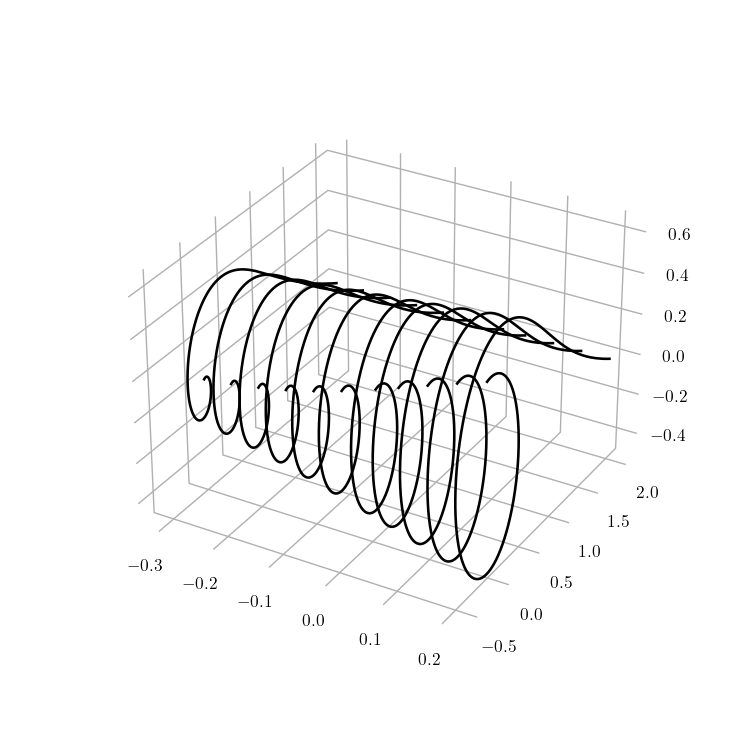

In [28]:
N_Trans = 11
trans_points = 800

# np.r_[x_real[:new_step*5], x_real[new_step*7:]]
x_trans = trans(x_real, trans_points, new_step, N_Trans)


fig = plt.figure(figsize=(6, 6))
plot_kws=dict(alpha=0.75, linewidth=2)

ax = fig.add_subplot(projection="3d")

for i in range(11):
    ax.plot(x_trans[i*trans_points:(i+1)*trans_points, 2],
            x_trans[i*trans_points:(i+1)*trans_points, 0],
            x_trans[i*trans_points:(i+1)*trans_points, 1], c='k', label='Trajectory')

# Adjust plot appearance
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 5
ax.zaxis.labelpad = 5

tuples = (0., 0., 0., 0.)

# Get rid of the panes
ax.xaxis.set_pane_color(tuples)
ax.yaxis.set_pane_color(tuples)
ax.zaxis.set_pane_color(tuples)

# Get rid of the spines (BIG LINES ON EDGES)
ax.xaxis.line.set_color(tuples)
ax.yaxis.line.set_color(tuples)
ax.zaxis.line.set_color(tuples)

# Set tick colors (little number line)
ax.xaxis.set_tick_params(color=tuples)
ax.yaxis.set_tick_params(color=tuples)
ax.zaxis.set_tick_params(color=tuples, left=True)

# plt.savefig('all_trans.svg')

In [29]:
cond_c = []
cond_c_c = []
cond_THETA = []
cond_trans = []
rango_alpha = np.logspace(-50, 40, num=50)

X = x_Trans
vals, dims = X.shape  # dims --> number of columns
    
# --> Initialize the return array.
library = PolynomialFeatures(coeffsw[-1])
THETA = library.fit_transform(X)
variable_names = library.fit(X[:2]).get_feature_names_out(['x', 'y', 'u'][0:dims])
l = len(variable_names)

# Initialize constraints -------------------------------------------------------------------------
n_constraints = pts_eq.shape[0] + ptss.shape[0] 
C = np.zeros((n_constraints, l))

for alpha in rango_alpha:
    idx = 0  # Index for row of C and element of vector d
    for p in ptss:         
        arr = list(library.fit_transform(np.array([p])).flatten())
        C[idx, :] = np.array(arr)
        idx += 1

    for p in pts_eq:         
        arr = list(library.fit_transform(np.array([p])).flatten())
        C[idx, :] = np.array(arr)
        idx += 1
        
    THETA_C = np.r_[THETA, np.sqrt(alpha)*C]

    cond_c.append(np.linalg.cond((C)))                   # PUNTOS RESTRICCION            np.sqrt(alpha)*
    cond_c_c.append(np.linalg.cond(THETA_C))             # TRANSIENTE + PUNTOS RESTRICCION
    cond_THETA.append(np.linalg.cond(THETA))             # SOLO TRANSIENTE
    cond_trans.append(np.linalg.cond(library.fit_transform(x_trans)))  # VARIOS TRANSIENTES

<IPython.core.display.Javascript object>


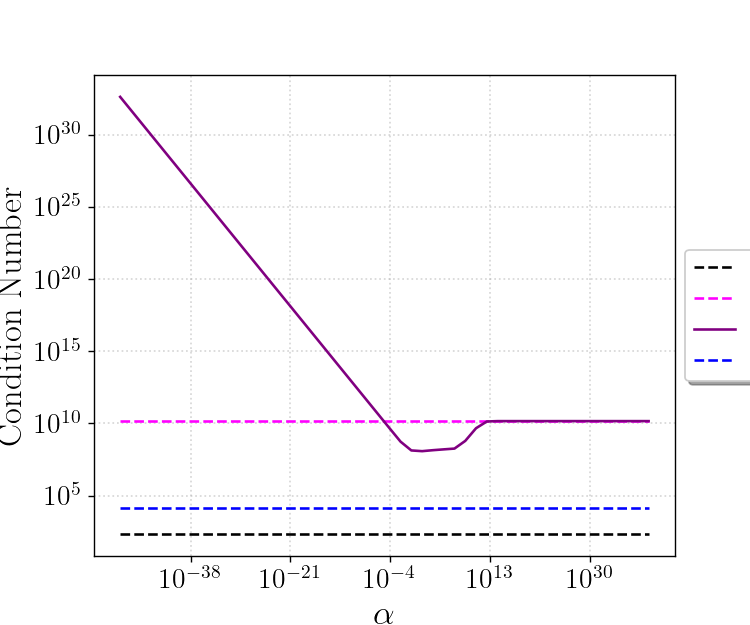

In [30]:
plt.figure(figsize=(6, 5))
plt.loglog(rango_alpha, cond_THETA, '--k', label=r'$\Theta(X)$: Single transient')
plt.loglog(rango_alpha, cond_c, 'magenta', linestyle='--', label=r'$\Theta(\sqrt{\alpha} C)$: Data in the attractor')
plt.loglog(rango_alpha, cond_c_c, 'purple', label=r'$\Theta(X) + \sqrt{\alpha}C$: Single transient + data in the attractor')
plt.loglog(rango_alpha, cond_trans, '--b', label='$\Theta(X_{total})$: '+str(N_Trans)+' transients')
plt.xlabel('$\\alpha$', fontsize=20)
plt.ylabel('Condition Number', fontsize=20)

plt.grid(True)  # Add major grid
plt.minorticks_on()  # Enable minor ticks
plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.5)  # Add minor grid
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, fontsize=12)

# Enlarge ticks
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=14)

# plt.savefig(r'C:\Users\javie\Dropbox\muSINDy\figures\hopf_condition.pdf', bbox_inches='tight')
# plt.savefig(r'hopf_condition_eng.png', dpi=500, bbox_inches='tight')
plt.show()